In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import json
import operator
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

from bgspy.genome import Genome
from bgspy.sim_utils import read_params, get_bounds
from bgspy.theory import bgs_segment
from bgspy.models import BGSModel 
from bgspy.utils import dist_to_segment, bin_chrom, haldanes_mapfun, signif
from bgspy.samplers import Sampler
from bgspy.utils import read_npy_dir


In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')


## Load Annotation

Load in human annotation to get a sense of the scale/range of parameters.

In [4]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_slop.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

m = BGSModel(g, 
             w_grid=np.array([1e-8]),
             t_grid=np.array([0.01]))

load_bed_annotation(): ignored chr19, chr21, chr2, chr6, chr22, chr18, chr3, chr17, chr4, chr1, chr9, chr16, chr20, chr15, chr8, chr14, chr11, chr5, chr13, chr12, chr7
ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chr19, chr21, chr2, chr6, chr22, chr18, chr3, chr17, chr4, chr1, chr9, chr16, chr20, chr15, chr8, chr14, chr11, chr5, chr13, chr12, chr7


/home/vsb/projects/bprime/bgspy/models.py:59: UserWarning: supplied Genome object has segment split lengths that differ from that specified -- resegmenting
  warnings.warn("supplied Genome object has segment split lengths that differ from that specified -- resegmenting")


completed segmenting chr10.
looking up map positions...	done.


## Size of Window to Sum Log Segment B Contributions over

This is mostly a visual test of these methods...

In [5]:
g._build_segment_idx_interpol()

building segment index interpolators... done.


In [6]:
g.get_segment_slice('chr10', 0.5e8)

(243260, 243260)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


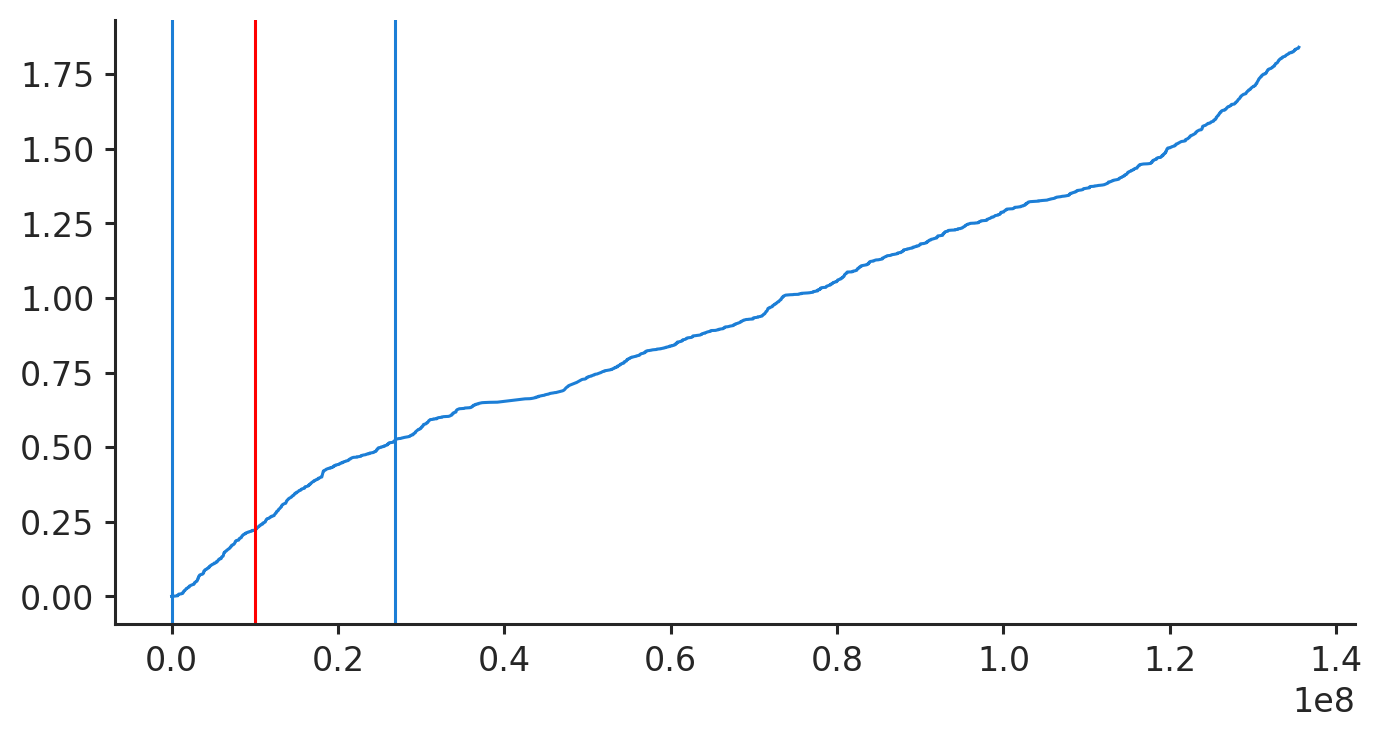

In [7]:
chrom = 'chr10'
x, y = g.recmap.cumm_rates[chrom]
plt.plot(x, y)

fpos = 0.1e8
a, b = g.get_segment_slice(chrom, pos=fpos, map_dist=0.3)
plt.axvline(fpos, c='r')
plt.axvline(g.segments.ranges[a, 0])
plt.axvline(g.segments.ranges[b, 0])


## Genomic Empirical Segments

What we've learned is that we need to mind the empirical distribution of genomic parameters (`L`, `rbp`, `rf`) when calculating B. We can calculate theory B for a given $\mu$ and $s$.


In [8]:
sels = [1e-1, 1e-2, 1e-3]
gst = [m.calc_stats(mu=1e-8, s=s) for s in sels]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.51it/s]


What does the distribution of theory B look like at some random individual sites?

The method used by `calc_stats()` is that random focal sites are sampled, and then B is calculated at these sites using all segments in the chromosome.

Text(0, 0.5, 'density')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


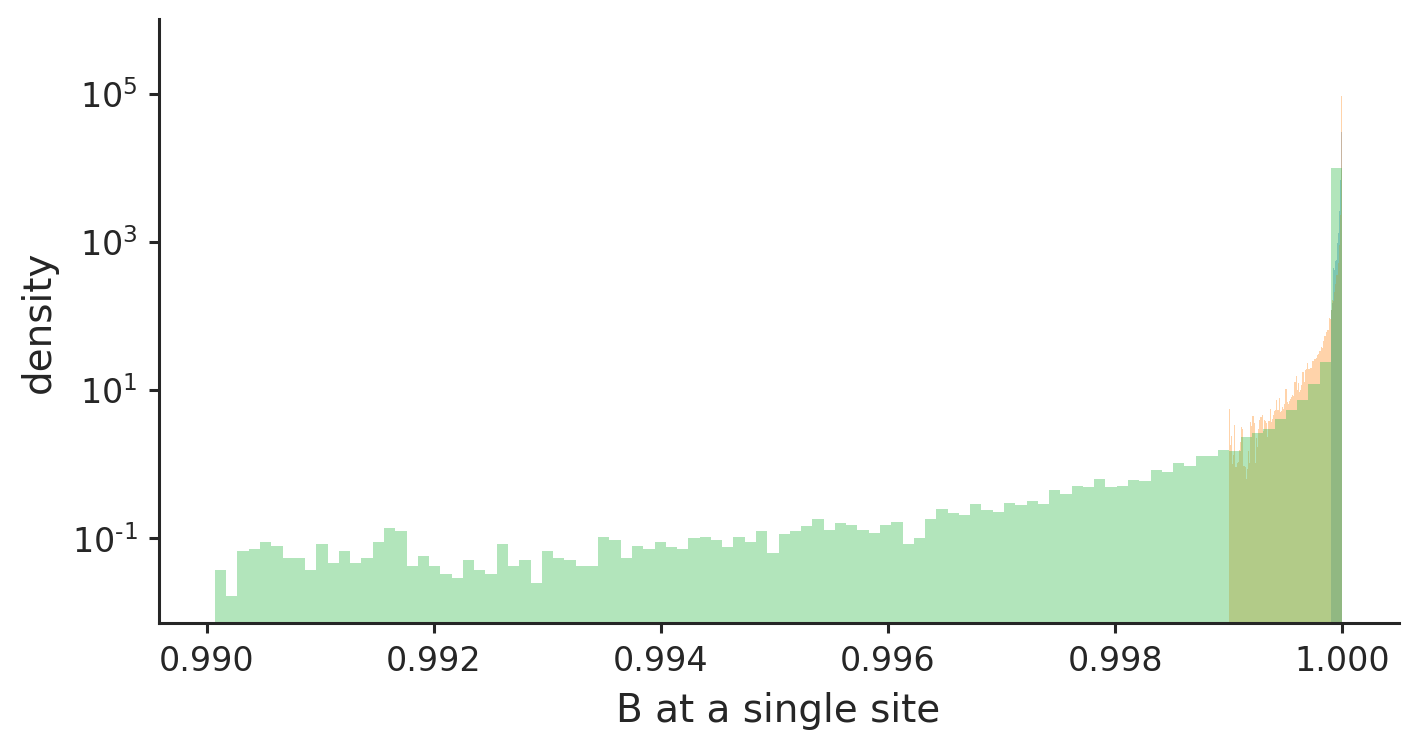

In [9]:
for i, s in enumerate(sels):
    _ = plt.hist(gst[i][3]['chr10'], 100, density=True, alpha=0.4, label=f"s={s}")
plt.semilogy()
plt.xlabel('B at a single site')
plt.ylabel('density')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


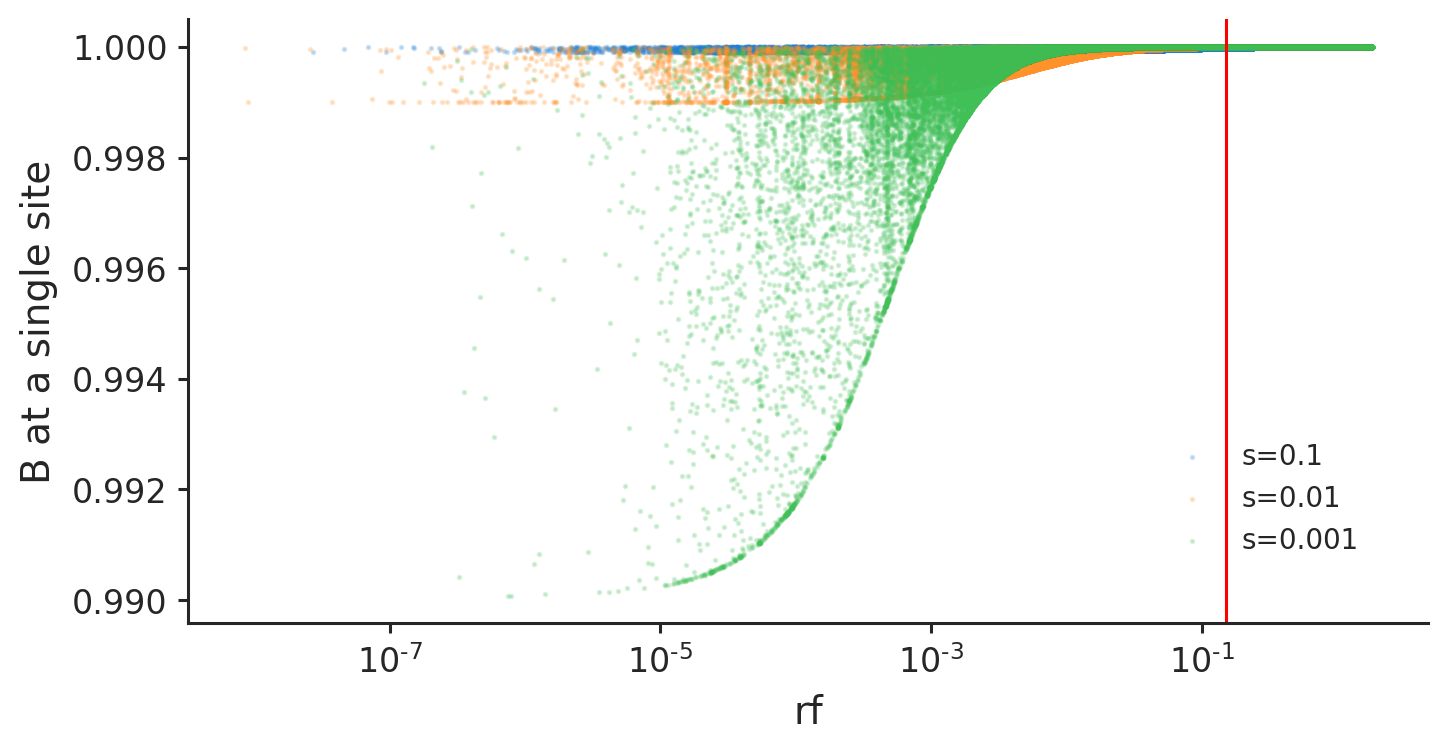

In [10]:
for i, s in enumerate(sels):
    plt.scatter(gst[i][2]['chr10'], gst[i][3]['chr10'], alpha=0.2, s=1, label=f"s={s}")
plt.semilogx()

rf_cutoff = 0.15
plt.axvline(rf_cutoff, c='r')
plt.xlabel('rf')
plt.ylabel('B at a single site')
plt.legend()

Text(0, 0.5, 'density')

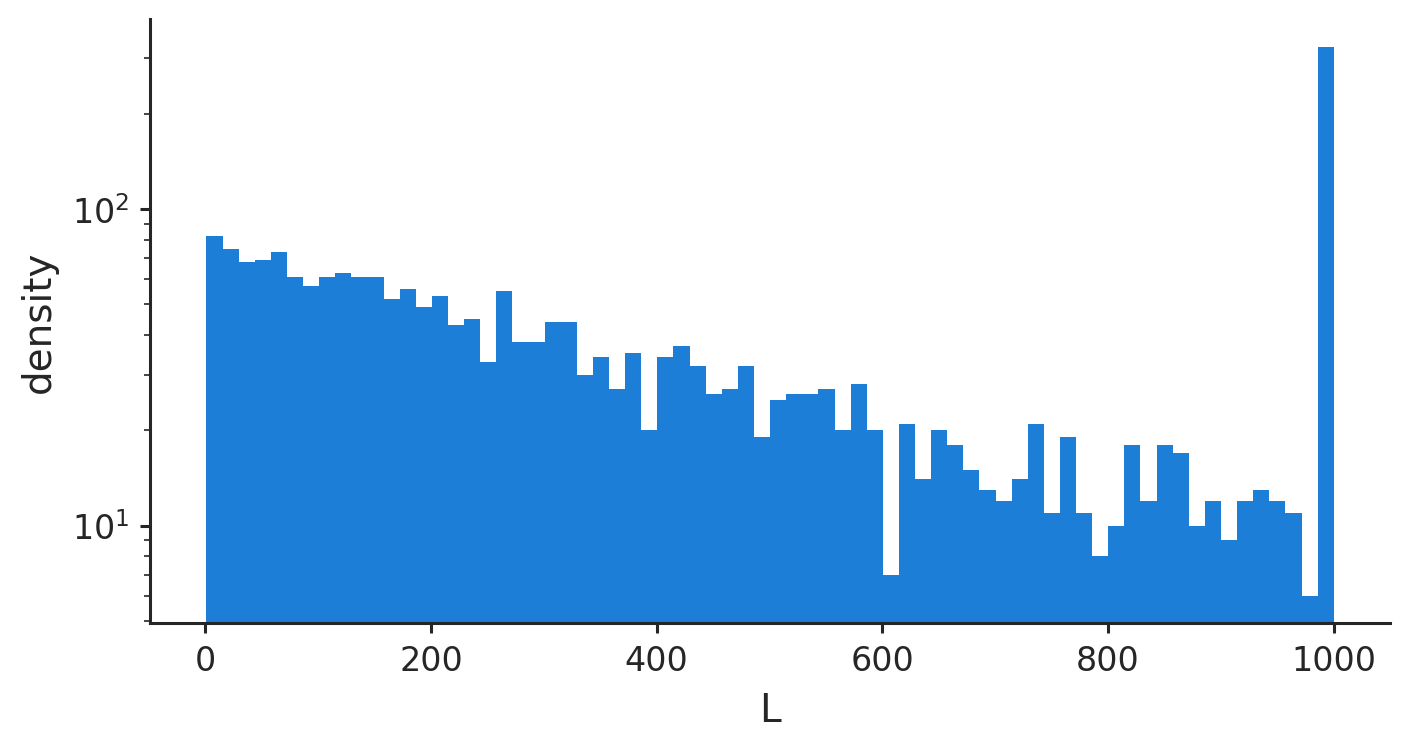

In [21]:
plt.hist(gst[i][0]['chr10'], 70, label=f"s={s}")
plt.semilogy()
plt.xlabel('L')
plt.ylabel('density')

Text(0, 0.5, 'density')

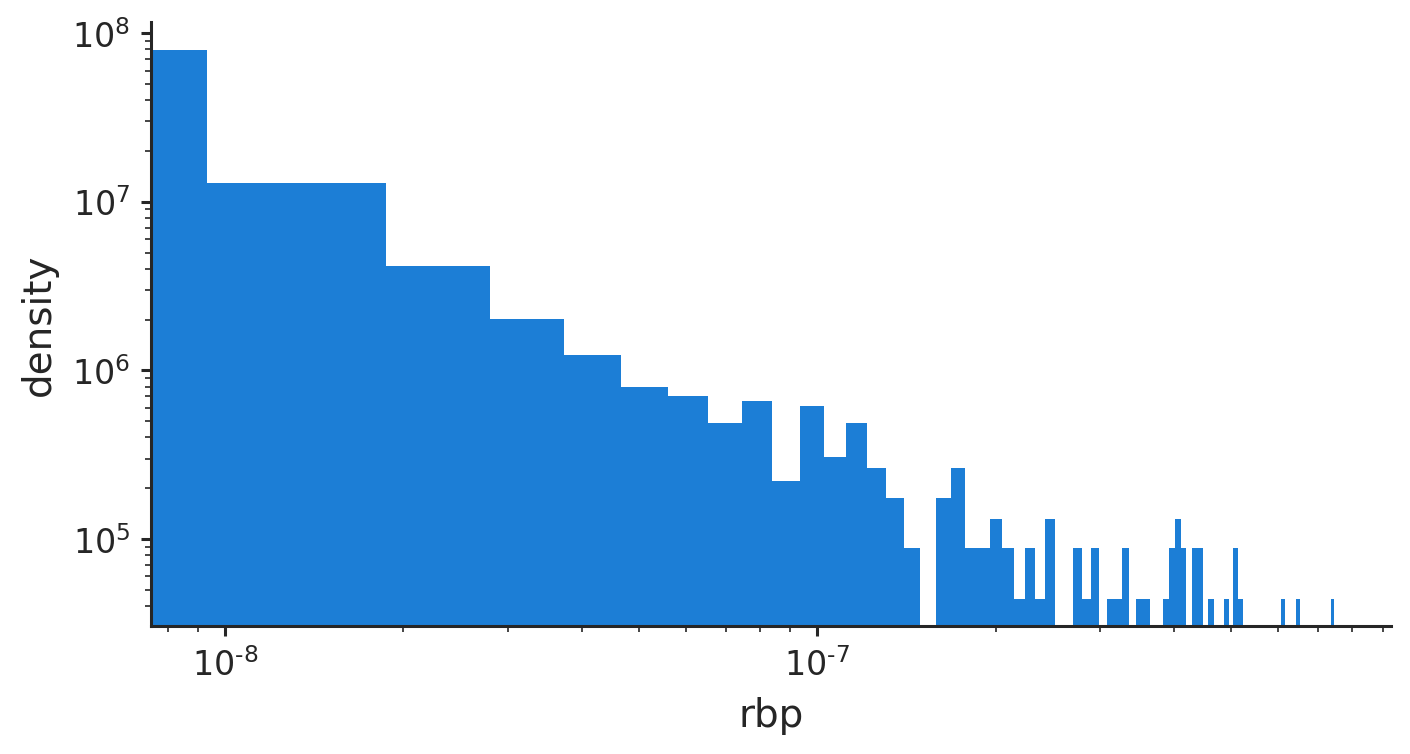

In [19]:
_ = plt.hist(gst[0][1]['chr10'], 80, density=True)
plt.loglog()
plt.xlabel('rbp')
plt.ylabel('density')

## OLD STUFF

## The Scale and Range of Parameters in the Human Genome


### Recombination
What's the range of recombination rates?

In [9]:
recmap = m.recmap

In [10]:
def flatten(loc, scale, factor=1.2):
    return loc, factor*scale

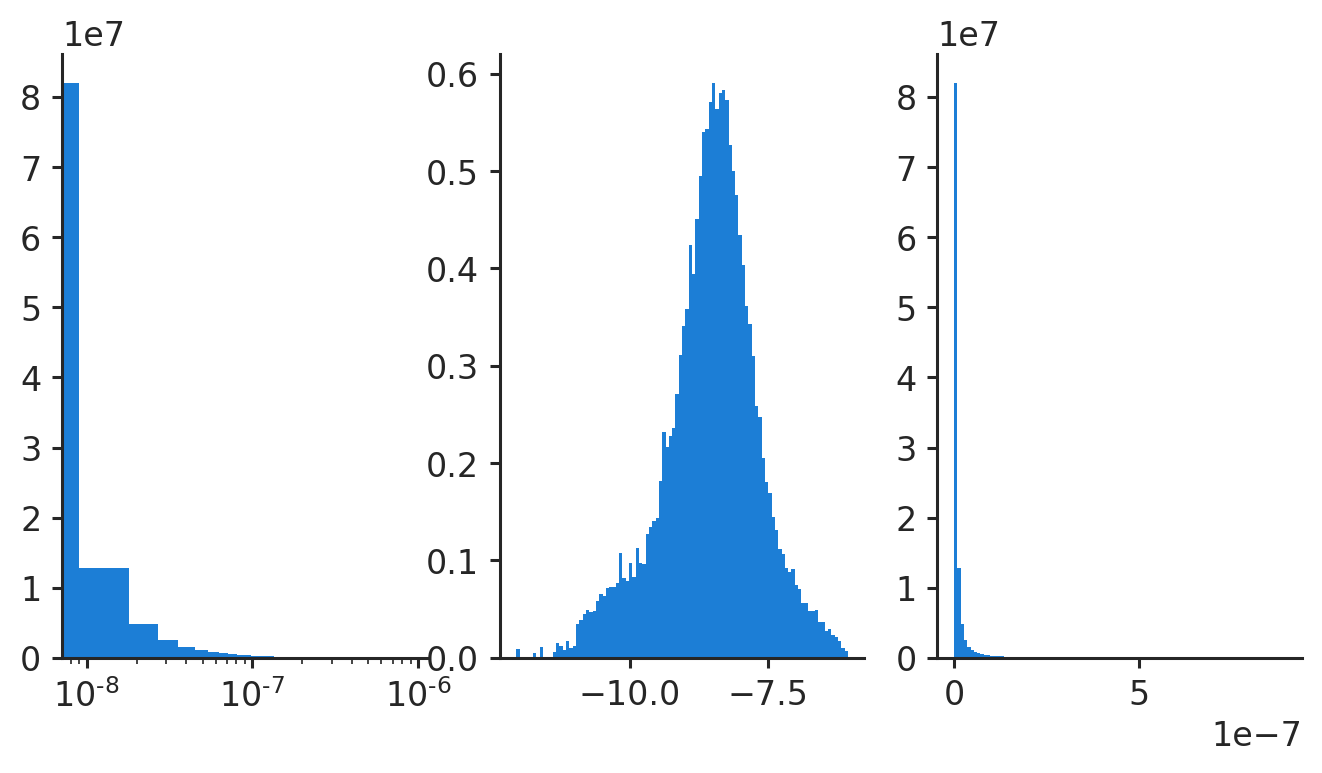

In [61]:
ends, rates = recmap.rates['chr10']
rates = rates[~np.isnan(rates)]
#log10_rates = np.log10(rates[rates>0])
fig, ax = plt.subplots(ncols=3)
ax[0].hist(rates, 100, density=True)
ax[1].hist(np.log10(rates[rates>0]), 100, density=True)
ax[0].set_xscale('log')
_ = ax[2].hist(rates, 100, density=True)

In [53]:
np.min(rates[rates > 0])

8.7e-13

matplotlib's log scaling is weird -- so I've shown it a few ways.

In [12]:
mode_height = stats.truncnorm(a, b, loc, scale).pdf(loc)
mode_height/stats.truncnorm(a, b, loc, scale).pdf(low), mode_height/stats.truncnorm(a, b, loc, scale).pdf(high)

(5.83097347716477, 6.55171789050818)

In [13]:
flattened_rbps_params_alt

(-8.541934686504534, 1.3118919357924543)

### What's the range of random recombination fractions?

Take a sample of positions, compute the map distances to all features, and look at the range and distribution of this.

In [14]:
x = np.random.uniform(0, recmap.cumm_rates['chr1'].rate[-1], 500)

In [15]:
y = np.array([dist_to_segment(f, m.segments.map_pos) for f in x]).flatten()

In [16]:
y[y > 0].min(), y[y > 0].max()

(2.8144819808062493e-11, 2.9359131986219915)

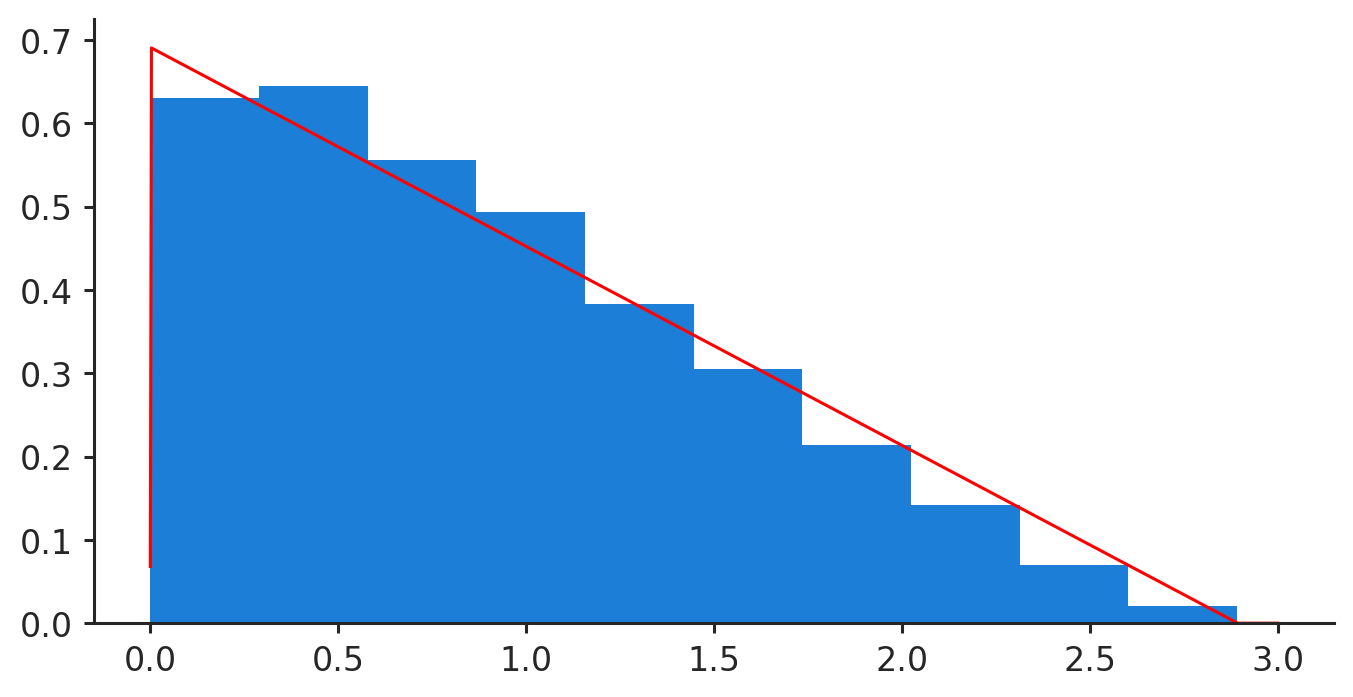

In [17]:
y_subsamp = y[np.random.randint(0, len(y), 10_000)]
rf_params = stats.triang.fit(y_subsamp)
x = np.linspace(0, 3, 1000)
plt.hist(y_subsamp, density=True)
#shape, location, scale = rf_params[0], rf_params[1], rf_params[2]*1.3
plt.plot(x, stats.triang(*rf_params).pdf(x), c='r')

(array([1.38505698, 1.48671254, 1.5798968 , 1.94416255, 2.15382714,
        2.30631048, 2.64304452, 2.82305957, 2.92683295, 1.92933779]),
 array([6.84455539e-05, 4.72867195e-02, 9.45049934e-02, 1.41723267e-01,
        1.88941541e-01, 2.36159815e-01, 2.83378089e-01, 3.30596363e-01,
        3.77814637e-01, 4.25032911e-01, 4.72251185e-01]),
 <BarContainer object of 10 artists>)

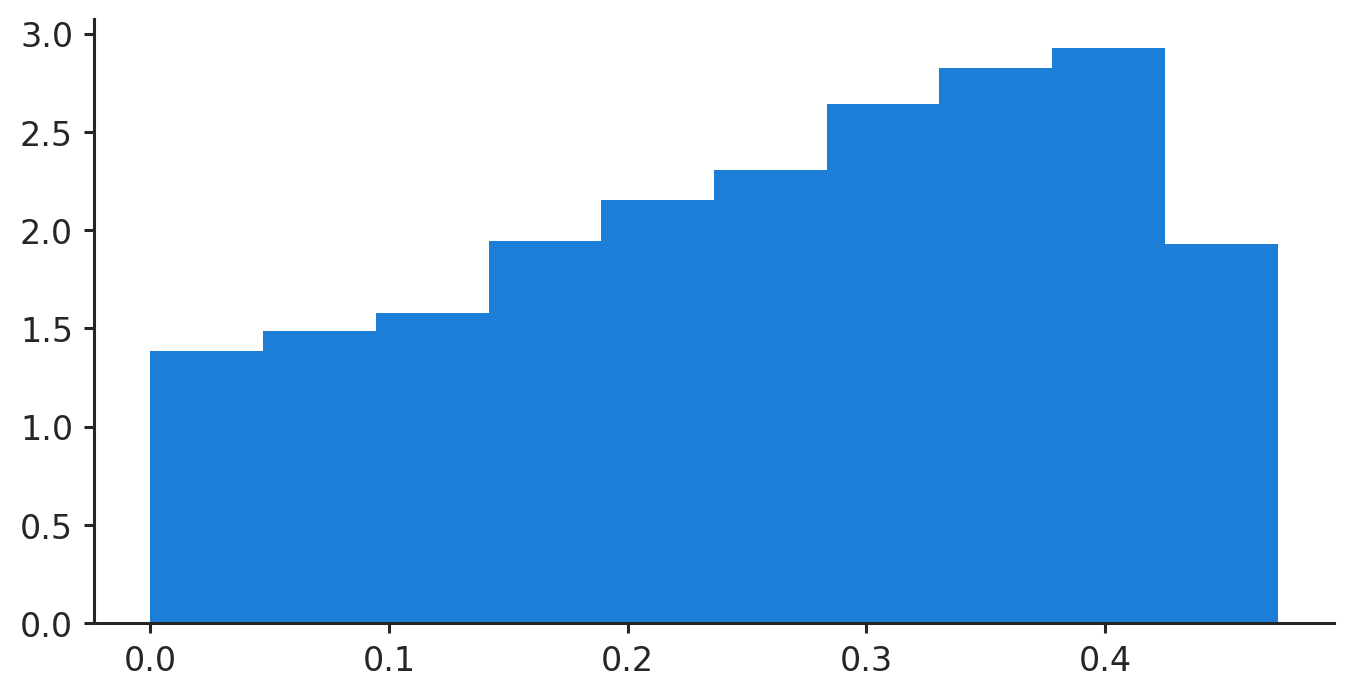

In [18]:
plt.hist(haldanes_mapfun(y_subsamp), density=True)

However there's a problem here — the $B$ values are quickly close to 1 for the bulk of this parameter space. We don't benefit in learning the functional form of $B$ by sampling in regions where it does not vary.

### What's the Range of Segment Lengths?

In [20]:
lengths = m.segments.lengths
log10_lengths = np.log10(lengths)
m.segments.lengths.min(), m.segments.lengths.max()

(1, 1000)

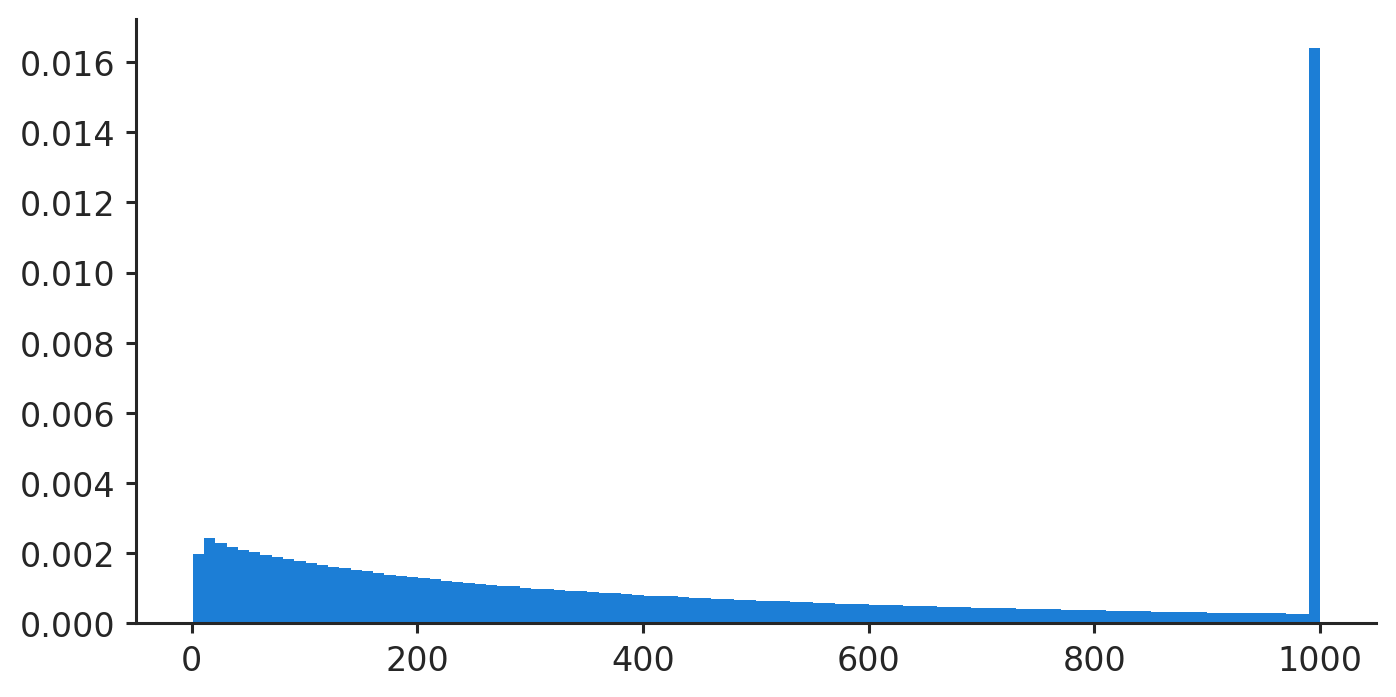

In [21]:
_ = plt.hist(lengths, 100, density=True)

## Parameters from JSON File

In [41]:
with open('../slim_sims/training/segment_logL_logrbp_logrf_wide.json') as f:
    params = json.load(f)['params']

sampler = Sampler(params, total=10000)
sampler

Sampler with 10000/10000 samples remaining, seed=1854555299
  N ~ fixed(val=1000)
  mu ~ log10_uniform(low=-10, high=-5)
  s ~ log10_uniform(low=-6, high=-1)
  h ~ fixed(val=0.5)
  rf ~ log10_uniform(low=-10, high=-2)
  rbp ~ log10_uniform(low=-10, high=-7)
  L ~ log10_uniform(low=-0.3, high=3.04)

In [42]:
sampler.generate()

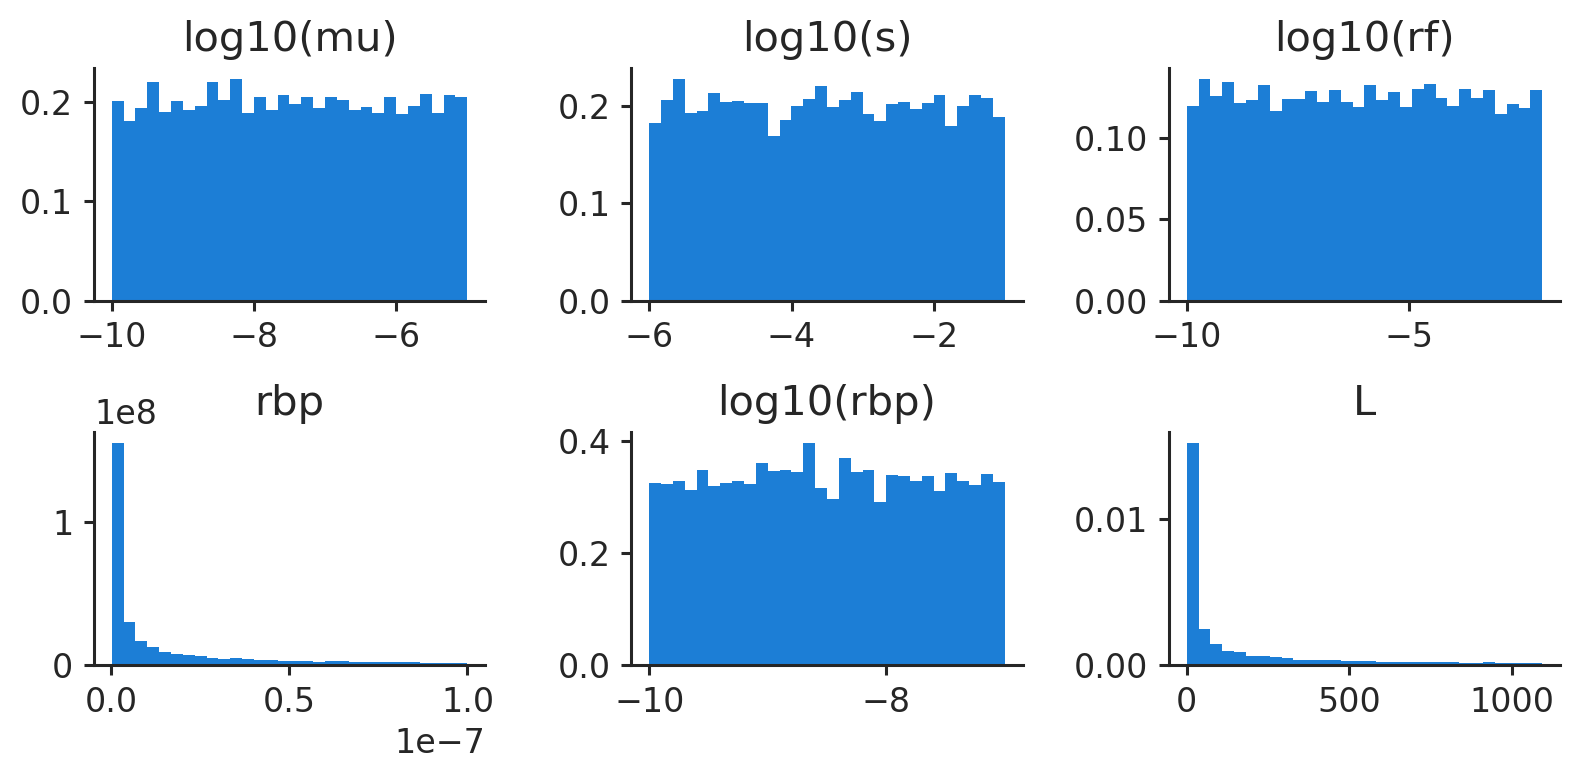

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=2)

plt_info = [(0, 0, 'mu', True), (0, 1, 's', True), (0, 2, 'rf', True), (1, 0, 'rbp', False), (1, 1, 'rbp', True), (1,  2, 'L', False)]
for i, j, var, log10 in plt_info:
    x = sampler[var]
    if log10:
        x = np.log10(x)
        var = f"log10({var})"
    ax[i, j].hist(x, 30, density=True)
    ax[i, j].set_title(var)
plt.tight_layout()

## $\mu/s$ Ratio

(array([ 209.,  571., 1093., 1368., 1837., 1783., 1311., 1000.,  629.,
         199.]),
 array([-8.95225425e+00, -7.95757075e+00, -6.96288726e+00, -5.96820376e+00,
        -4.97352026e+00, -3.97883676e+00, -2.98415326e+00, -1.98946976e+00,
        -9.94786265e-01, -1.02766306e-04,  9.94580732e-01]),
 <BarContainer object of 10 artists>)

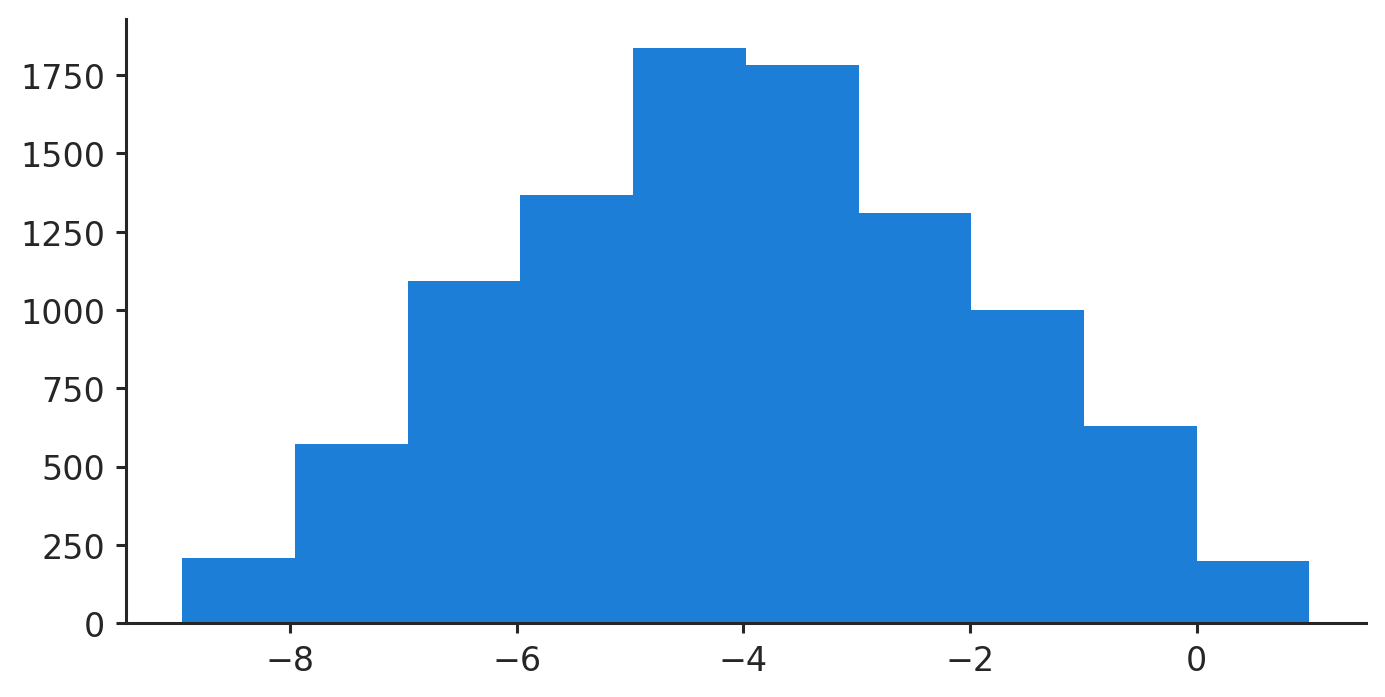

In [44]:
plt.hist(np.log10(sampler['mu']/sampler['s']))

## Prediction Chunks 

Unnormalized, for comparison and getting a sense of how parameters vary.

**Note:** these are what's fed directly into prediction, so the rows are duplicated in the matrix design (so it can later be reshaped into a tensor).

In [64]:
Xps = list(map(operator.itemgetter(1), sorted(read_npy_dir('../data/dnnb/xps/chr10/').items(), key=lambda x: x[0])))

/tmp/ipykernel_22623/2358572697.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Xps_sample = np.concatenate(np.random.choice(Xps, 10), axis=0)


Text(0.5, 0, 'B')

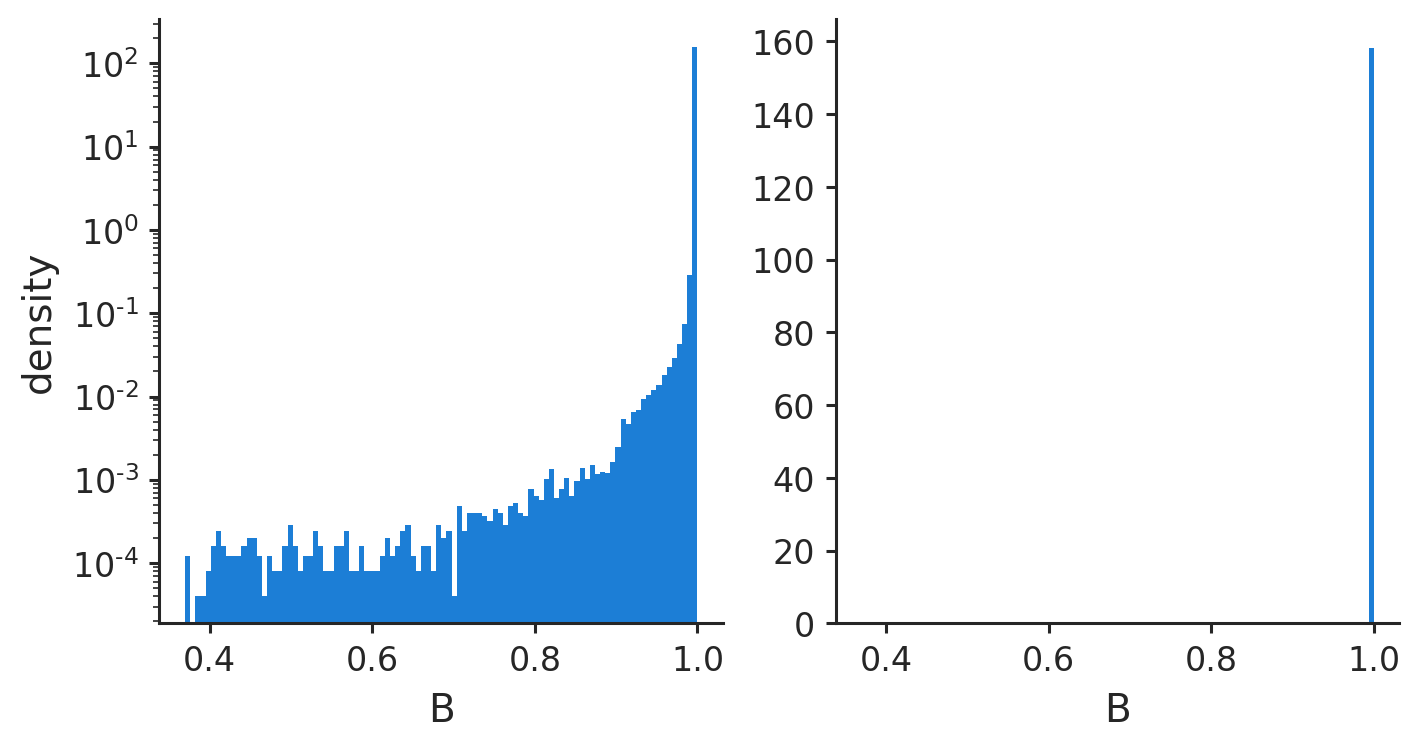

In [66]:
Xps_sample = np.concatenate(np.random.choice(Xps, 10), axis=0)
b_sample = bgs_segment(*Xps_sample.T)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(b_sample, 100, density=True)
ax1.semilogy()
ax1.set_ylabel('density')
_ = ax2.hist(b_sample, 100, density=True)
ax1.set_xlabel('B')
ax2.set_xlabel('B')

Now let's compare the parameters fed into the prediction (based on genome) with those we have simulated under:

In [67]:
sampler.generate()

In [68]:
sampler['s']

array([0.07331  , 0.05856  , 0.0007259, ..., 0.0007878, 0.05701  ,
       0.0002991])

[]

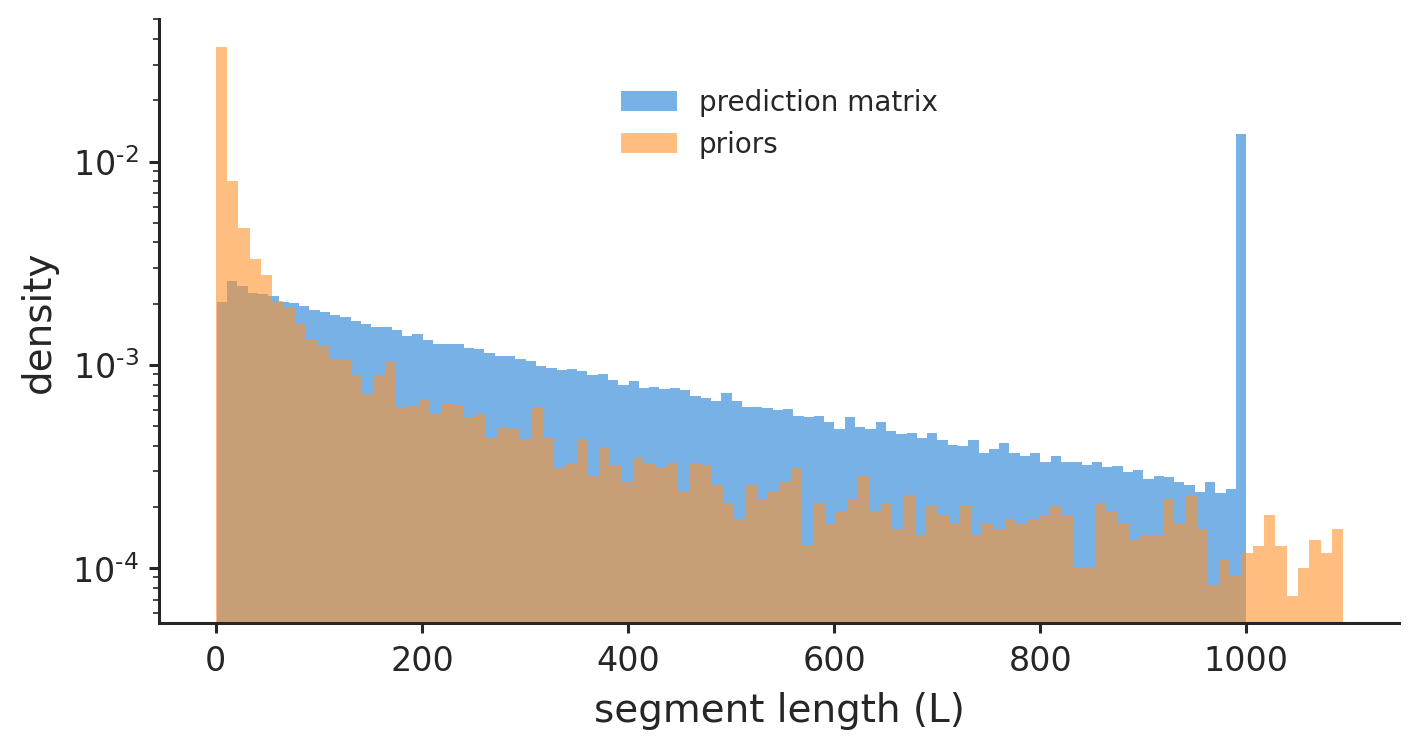

In [149]:
_ = plt.hist(Xps_sample[:, 2], 100, density=True, label="prediction matrix", alpha=0.6)
_ = plt.hist(sampler['L'], 100, density=True, label="priors", alpha=0.6)

#x = Xps_sample[:, 2][:, None]
#xmin, xmax = np.min(x), np.max(x)
#x_grid = np.linspace(xmin, xmax, 100)[:, None]
#dens = KernelDensity(kernel='gaussian', bandwidth=10).fit(x).score_samples(x_grid)
#plt.plot(x_grid, np.exp(dens))

plt.ylabel('density')
plt.xlabel('segment length (L)')
plt.legend()
plt.semilogy()

In [126]:
from sklearn.neighbors import KernelDensity

[]

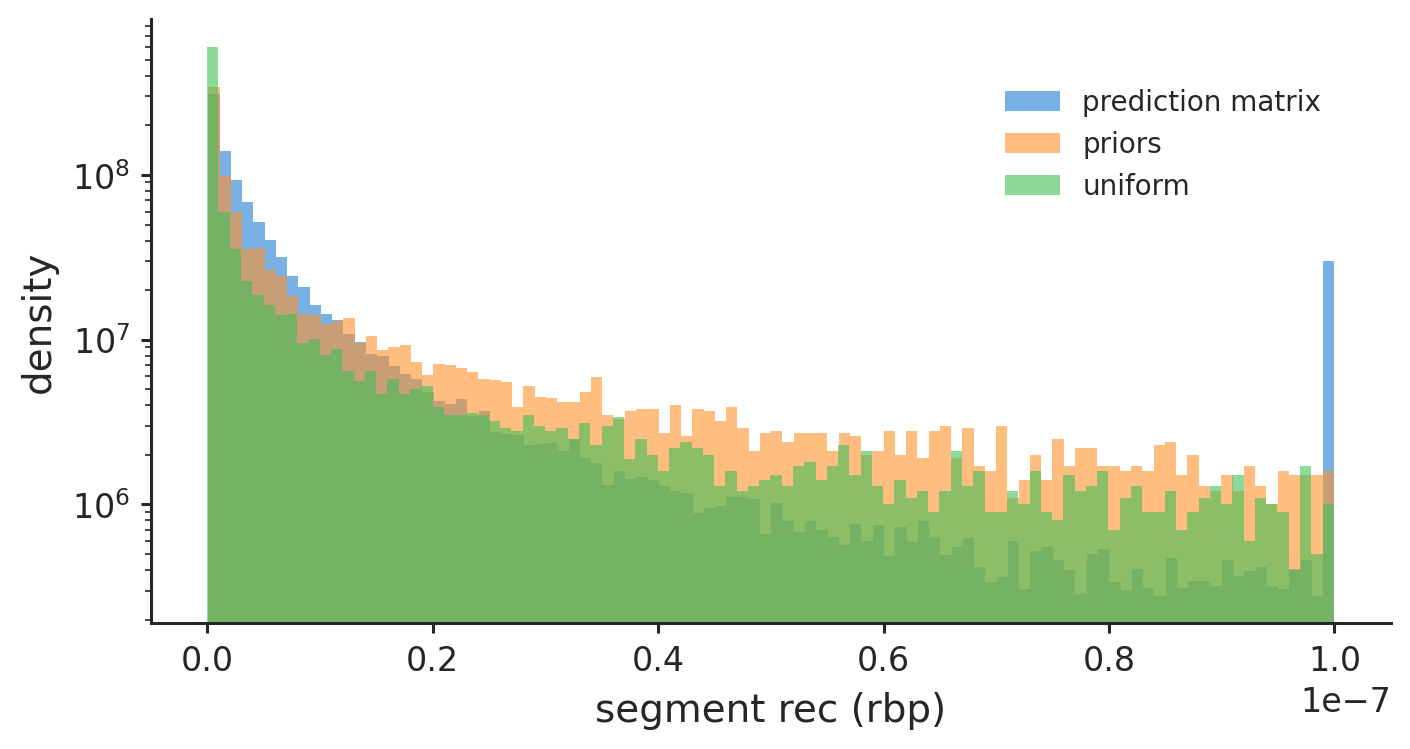

In [161]:
_ = plt.hist(Xps_sample[:, 3], 100, density=True, label="prediction matrix", alpha=0.6)
_ = plt.hist(sampler['rbp'], 100, density=True, label="priors", alpha=0.6)
_ = plt.hist(10**np.random.uniform(-12, -7, 10000), 100, density=True, label="uniform", alpha=0.6)
plt.ylabel('density')
plt.xlabel('segment rec (rbp)')
plt.legend()
plt.semilogy()

In [232]:
1e-2, haldanes_mapfun(0.1)

(0.01, 0.04758129098202024)

In [235]:
from bgspy.utils import haldanes_mapfun, inverse_haldanes_mapfun

In [237]:
inverse_haldanes_mapfun(0.1)

0.11157177565710484

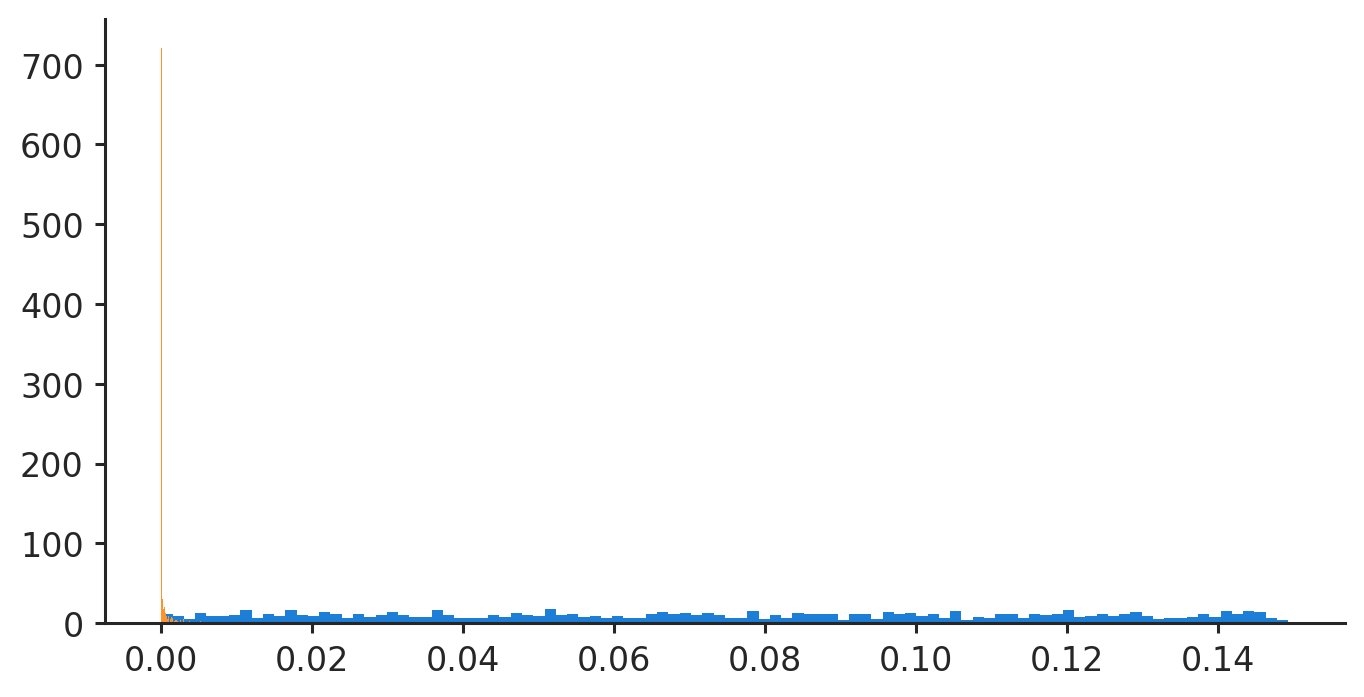

In [240]:
n = 1000
plt.hist(np.random.uniform(0, 0.15, n), 100)
_ = plt.hist(10**np.random.uniform(-10, -2, n), 100)

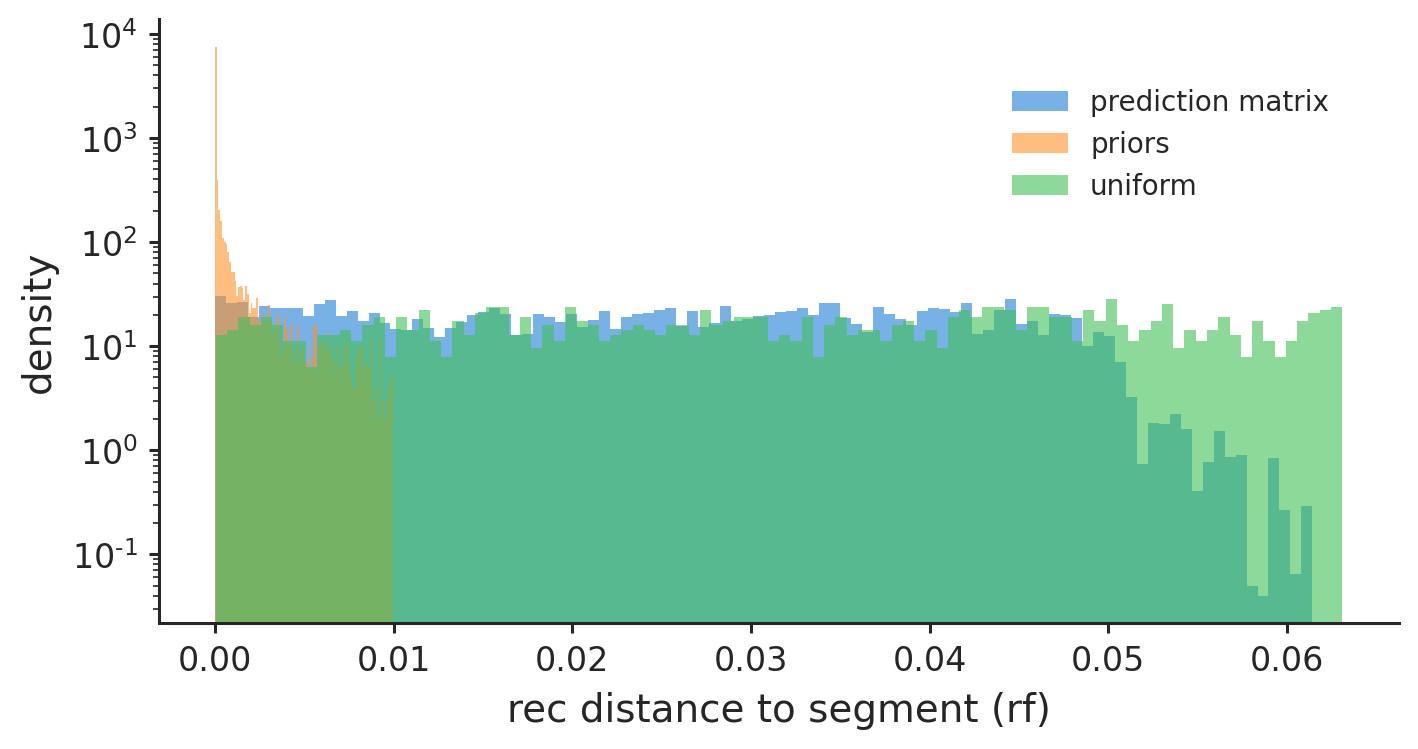

In [234]:
_ = plt.hist(haldanes_mapfun(Xps_sample[:, 4]), 100, density=True, label="prediction matrix", alpha=0.6)
_ = plt.hist(sampler['rf'], 100, density=True, label="priors", alpha=0.6) 
_ = plt.hist(haldanes_mapfun(np.random.uniform(0, 0.135, 1000)), 100, density=True, label="uniform", alpha=0.6) 

plt.ylabel('density')
plt.xlabel('rec distance to segment (rf)')
#plt.loglog()
plt.semilogy()
plt.legend(loc='upper right')

In [200]:
sampler_b = bgs_segment(sampler['mu'], sampler['s'], sampler['L'], sampler['rbp'], sampler['rf'])
prediction_b = bgs_segment(*Xps_sample.T)

In [201]:
(sampler_b == 0).sum(), (prediction_b == 0).sum()

(4, 0)

In [219]:
FIT_DIR = '../data/slim_sims/segment_logL_logrbp_logrf_wide/fits/'

models = [f for f in os.listdir(FIT_DIR)]
#models = ['segment_uniform_mu']
from bgspy.nb_utils import load_learnedfuncs_in_dir

res = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}



res.keys()
segmodel = res['segment_logL_logrbp_logrf_wide']

2022-05-13 16:42:13.850514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 16:42:19.150128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1311 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-13 16:42:19.151167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6120 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-13 16:42:19.152123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica

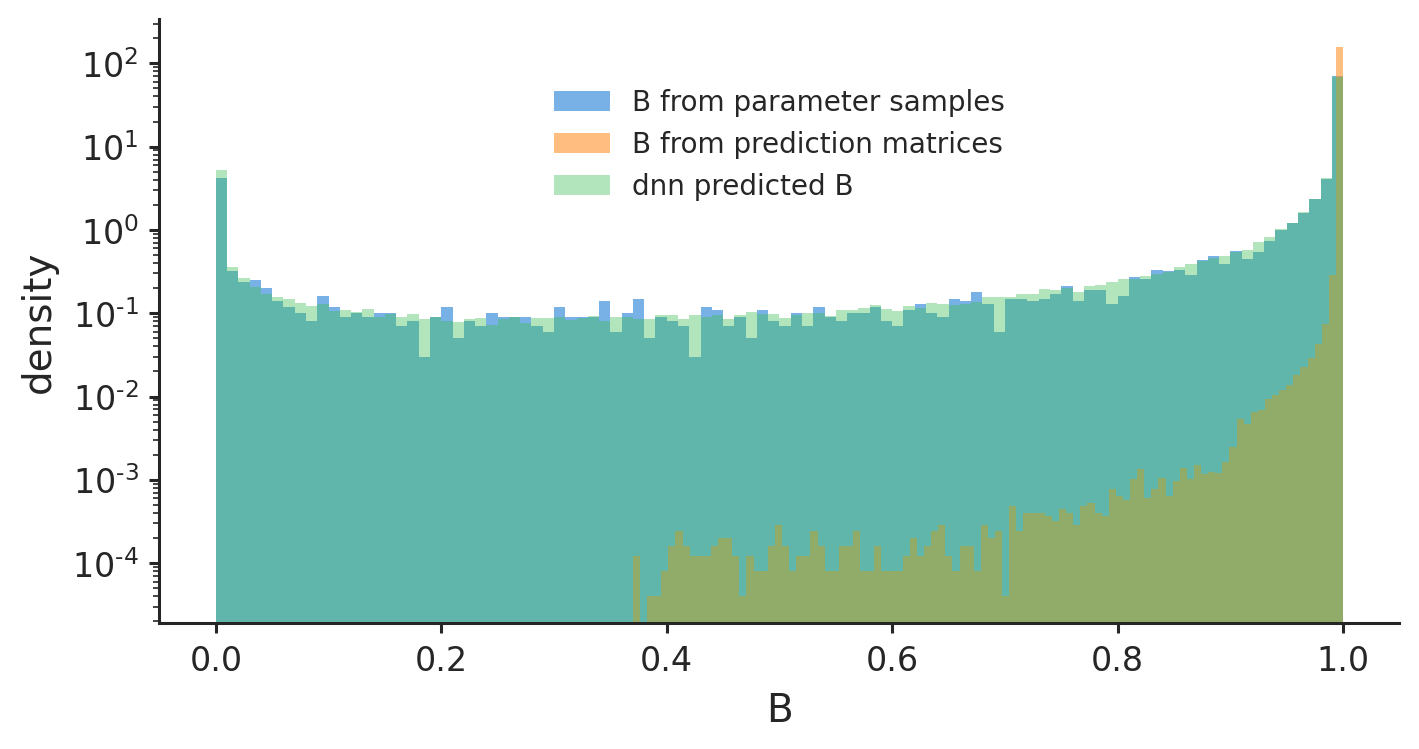

In [223]:
plt.hist(sampler_b, 100, label='B from parameter samples', density=True, alpha=0.6)
plt.hist(prediction_b, 100, label='B from prediction matrices',  density=True,alpha=0.6)
_ = plt.hist(segmodel[(0, 0, 0, 0, 2)][0].theory_B(), 100, label='dnn predicted B',  density=True,alpha=0.4)
plt.semilogy()
plt.ylabel('density')
plt.xlabel('B')
plt.legend()

In [203]:
np.random.permutation(np.arange(10))

array([7, 3, 2, 0, 1, 6, 4, 8, 5, 9])

How do things look if we break correlations in the real genome data?

In [204]:
sampler_b = bgs_segment(sampler['mu'], sampler['s'], sampler['L'], sampler['rbp'], sampler['rf'])

Xps_permut = []
for col in Xps_sample.T:
    Xps_permut.append(np.random.permutation(col))
    
Xps_permut = np.array(Xps_permut).T
prediction_permut_b = bgs_segment(*Xps_permut.T)

In [205]:
# let's mimic simple samples
Xps_unif = np.copy(Xps_permut)
n = Xps_unif.shape[0]
Xps_unif[:, 2] = np.random.randint(1, 1000, n)

# how can we make this fit Bs?  
Xps_unif[:, 3] = 10**np.random.uniform(-12, -7, n)
#Xps_unif[:, 3] = Xps_sample[:, 3]
Xps_unif[:, 4] = np.random.uniform(0, 0.135, n)

unif_b = bgs_segment(*Xps_unif.T)

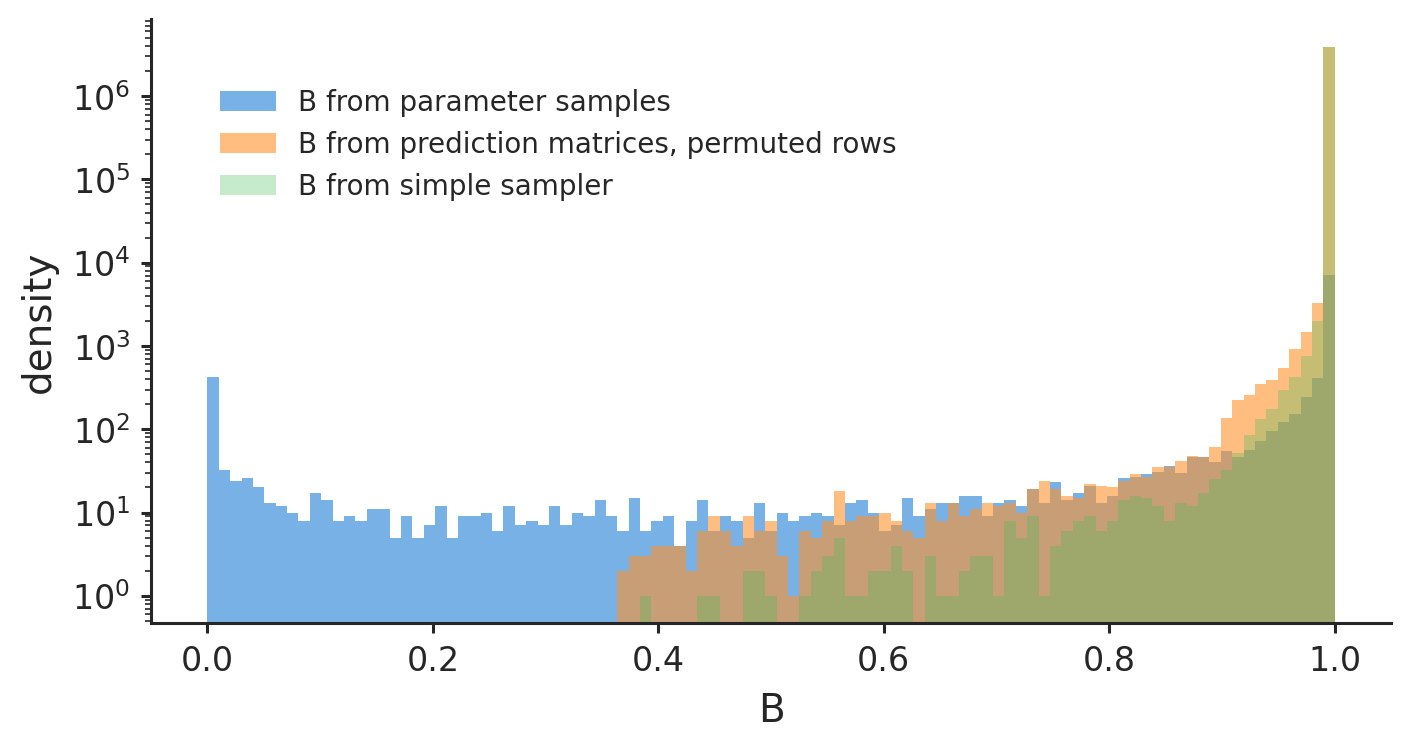

In [227]:
bins = np.linspace(0, 1, 100)
plt.hist(sampler_b, bins, label='B from parameter samples', alpha=0.6)
#plt.hist(prediction_b, bins, label='B from prediction matrices', alpha=0.6)
plt.hist(prediction_permut_b, bins, label='B from prediction matrices, permuted rows', alpha=0.6)
plt.hist(unif_b, bins, label='B from simple sampler', alpha=0.3)
plt.semilogy()
plt.ylabel('density')
plt.xlabel('B')
plt.legend()

In [216]:
b

1.938931297709923

In [214]:
h = 0.03
sh = 0.01

s = sh / h
s

0.33333333333333337

### Expected Reductions under Classic BGS

In [34]:
sim_bounds = get_bounds(params)
sim_bounds

{'N': (1000, 1000, False),
 'mu': (-10, -5, True),
 's': (-6, -1, True),
 'h': (0.5, 0.5, False),
 'rf': (-10, -2, True),
 'rbp': (-10, -7, True),
 'L': (-0.3, 3.04, True)}

In [35]:
kwargs_lower, kwargs_upper = {}, {}

kwargs = ('mu', 's', 'rf', 'rbp', 'L')
# B is inversely proportional to these things under classic BGS
swap = ('s', 'rf', 'rbp')
for key, (lower, upper, log10) in sim_bounds.items():
    if key not in kwargs:
        continue
    if log10:
        lower, upper = 10**lower, 10**upper
    if key in swap:
        lower, upper = upper, lower
    kwargs_lower[key] = lower
    kwargs_upper[key] = upper

In [36]:
kwargs_lower, kwargs_upper

({'mu': 1e-10, 's': 0.1, 'rf': 0.01, 'rbp': 1e-07, 'L': 0.5011872336272722},
 {'mu': 1e-05, 's': 1e-06, 'rf': 1e-10, 'rbp': 1e-10, 'L': 1096.4781961431852})

In [37]:
bgs_segment(**kwargs_lower), bgs_segment(**kwargs_upper)

(array(1.), array(0.))

In [38]:
# how much should rf vary?
rfs = np.logspace(-10, 0, 100)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


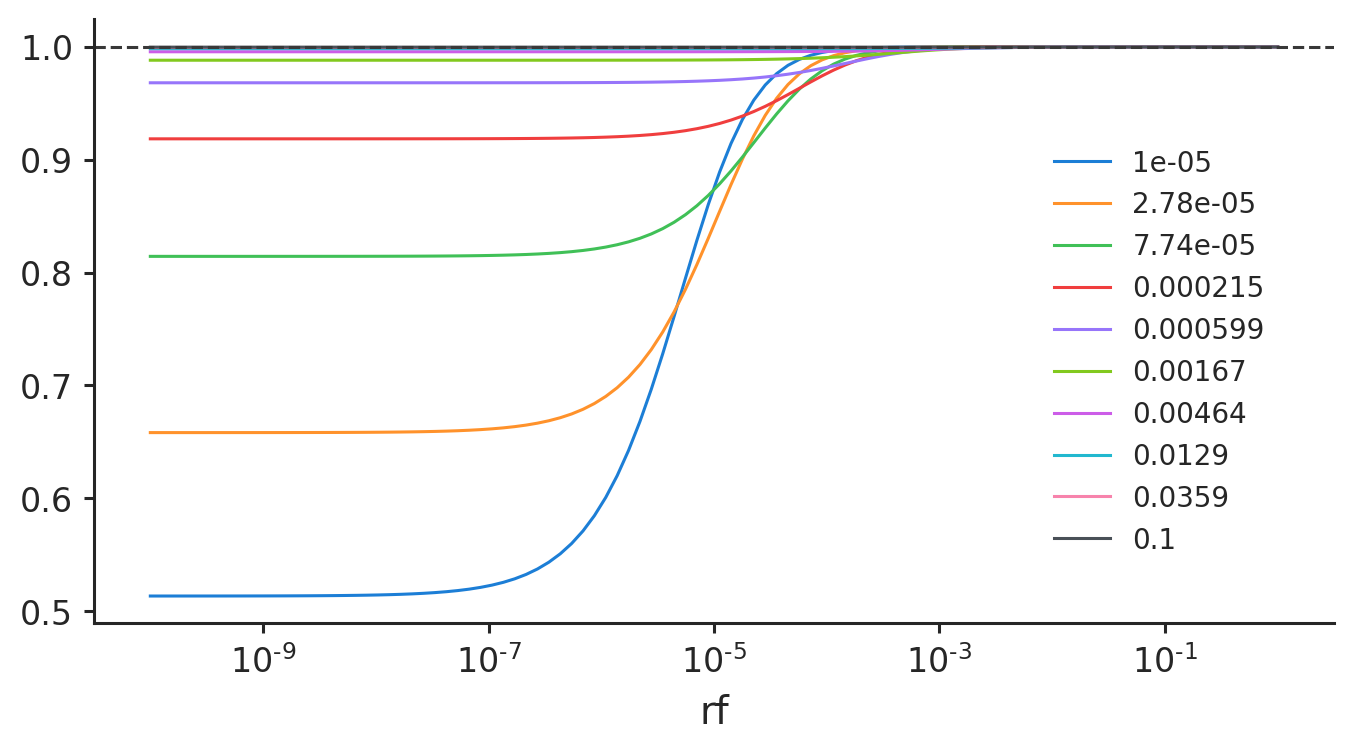

In [39]:
selcoefs = 10**np.linspace(-5, -1, 10)

fig, ax = plt.subplots()
for i, s in enumerate(selcoefs):
    kwargs = {'mu': 1e-08, 's': s, 'rf': rfs, 'rbp': 1e-8, 'L': 1000}
    B = bgs_segment(**kwargs)
    ax.plot(rfs, B, label=signif(s, 3))
ax.axhline(1, c='0.22', linestyle='dashed')
ax.set_xlabel('rf')
ax.set_xscale('log')
ax.legend()

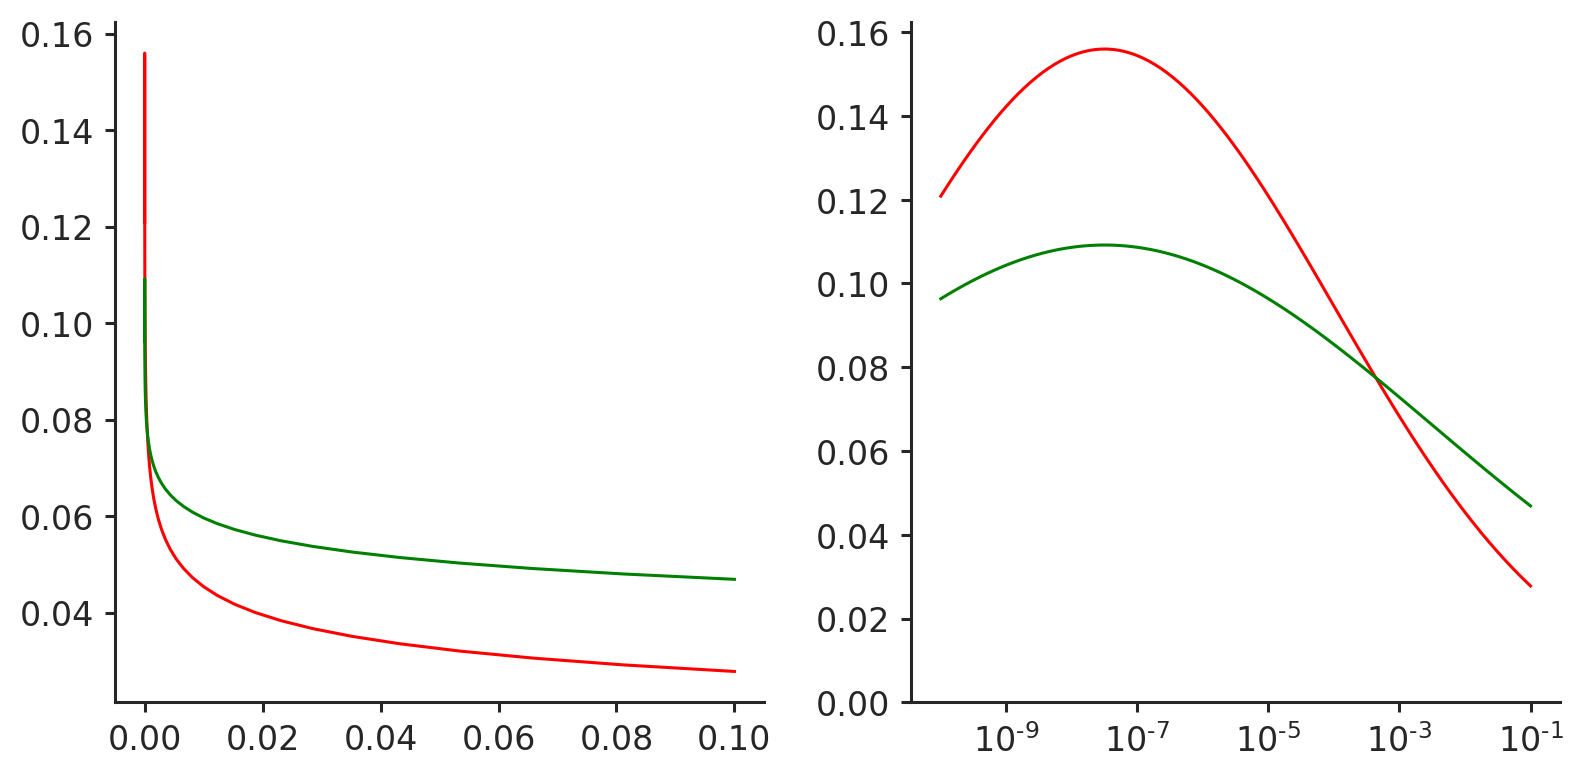

In [40]:
fig, ax = plt.subplots(ncols=2)
low, high, loc, scale = -10, -1, -7.5, 3.5
a = (low - loc)/scale
b = (high - loc)/scale
x = 10**np.linspace(-10, -1, 100)
ax[0].plot(x, stats.truncnorm(a, b, loc, scale).pdf(np.log10(x)), c='r')
ax[1].plot(x, stats.truncnorm(a, b, loc, scale).pdf(np.log10(x)), c='r')
ax[1].plot(x, stats.truncnorm(a, b, loc, 5).pdf(np.log10(x)), c='g')
ax[0].plot(x, stats.truncnorm(a, b, loc, 5).pdf(np.log10(x)), c='g')

#ax[1].plot(x, stats.loguniform(10**low, 10**high).pdf(x), c='b')
#ax[1].set_ylim(0, 0.2)
#ax[1].set_xlim(10**low, 10**high)
ax[1].set_ylim(0)
ax[1].semilogx()
plt.tight_layout()